<a href="https://colab.research.google.com/github/namtoptall/DataScience/blob/main/transfer_learning_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chạy lại lab :


In [1]:
# Chúng ta có đang sử dụng GPU không?!
!nvidia-smi

Mon Jul 22 10:46:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# # Lấy dữ liệu (10% nhãn)
# import zipfile

# # Download dữ liệu
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# # Giải nén dữ liệu đã download
# zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
# zip_ref.extractall()
# zip_ref.close()

--2024-07-22 10:46:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  81.6MB/s    in 2.0s    

2024-07-22 10:46:42 (81.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# check tensorflow version
import tensorflow as tf
print(tf.__version__)

2.15.0


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
import os

# Walk through 10 % data directory and list number of files
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [6]:
# import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [7]:
# Load data in from directories and flow into batches
print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical')

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [8]:
# create call_back
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [9]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [10]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Ban đầu: EfficientNetB0 feature vector (ver 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # Mới: EfficientNetB0 feature vector (ver 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [11]:
# prompt: def create_model(model_url, num_classes=10):

def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and add it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model


In [12]:
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

resnet_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [13]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Thêm callback TensorBoard vào mô hình
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])


Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240722-104659
Epoch 1/5
24/24 [==============================] - 26s 670ms/step - loss: 1.9402 - accuracy: 0.3707 - val_loss: 1.1860 - val_accuracy: 0.6388
Epoch 2/5
24/24 [==============================] - 12s 495ms/step - loss: 0.8839 - accuracy: 0.7307 - val_loss: 0.8142 - val_accuracy: 0.7340
Epoch 3/5
24/24 [==============================] - 11s 452ms/step - loss: 0.6116 - accuracy: 0.8227 - val_loss: 0.7411 - val_accuracy: 0.7496
Epoch 4/5
24/24 [==============================] - 11s 478ms/step - loss: 0.4763 - accuracy: 0.8707 - val_loss: 0.6759 - val_accuracy: 0.7760
Epoch 5/5
24/24 [==============================] - 11s 472ms/step - loss: 0.3776 - accuracy: 0.9200 - val_loss: 0.6627 - val_accuracy: 0.7808


In [14]:
# Nếu muốn, bạn có thể biến nó thành hàm hỗ trợ để load với script helper.py
import matplotlib.pyplot as plt

# Vẽ biểu đồ dữ liệu huấn luyện và kiểm định một cách riêng biệt
def plot_loss_curves(history):
  """
  Trả về các loss curve riêng cho các phép đo huấn luyện và kiểm định.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Vẽ loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Vẽ accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

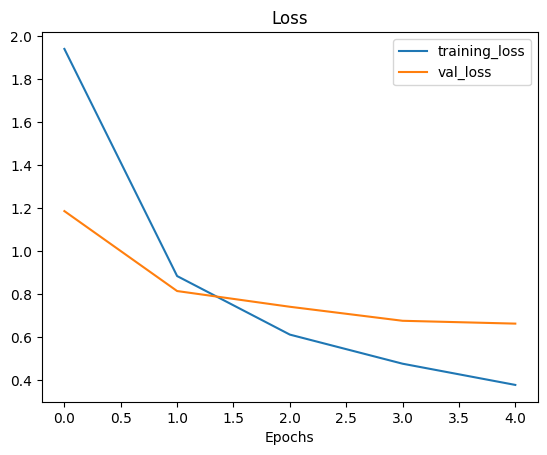

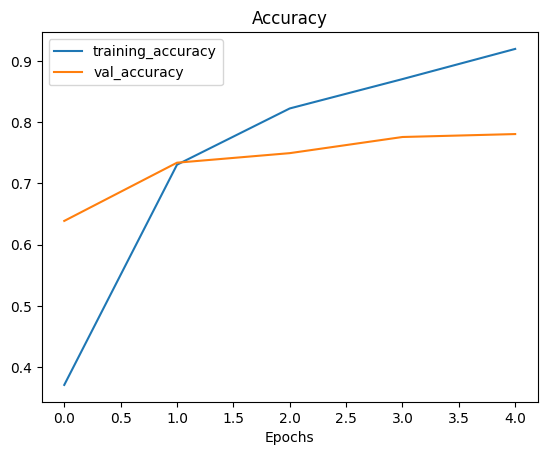

In [15]:
plot_loss_curves(resnet_history)

In [16]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [17]:
efficientnet_model = create_model(efficientnet_url, num_classes=train_data_10_percent.num_classes)

efficientnet_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="efficientnetB0")]
                                              )

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20240722-104900
Epoch 1/5
24/24 [==============================] - 23s 554ms/step - loss: 1.8318 - accuracy: 0.4280 - val_loss: 1.3114 - val_accuracy: 0.7160
Epoch 2/5
24/24 [==============================] - 10s 409ms/step - loss: 1.0646 - accuracy: 0.7733 - val_loss: 0.8778 - val_accuracy: 0.8172
Epoch 3/5
24/24 [==============================] - 10s 432ms/step - loss: 0.7576 - accuracy: 0.8293 - val_loss: 0.7074 - val_accuracy: 0.8408
Epoch 4/5
24/24 [==============================] - 10s 429ms/step - loss: 0.6090 - accuracy: 0.8667 - val_loss: 0.6207 - val_accuracy: 0.8552
Epoch 5/5
24/24 [==============================] - 13s 540ms/step - loss: 0.5160 - accuracy: 0.8933 - val_loss: 0.5675 - val_accuracy: 0.8616


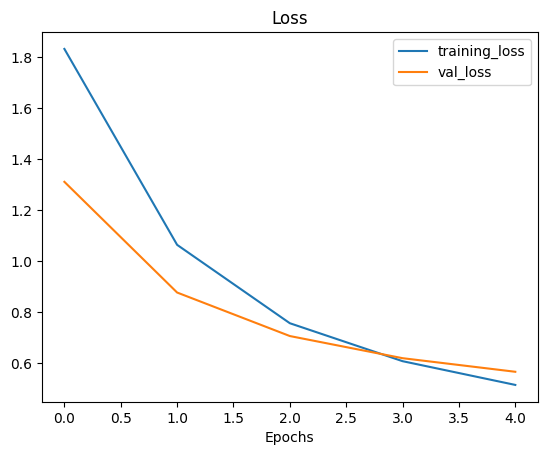

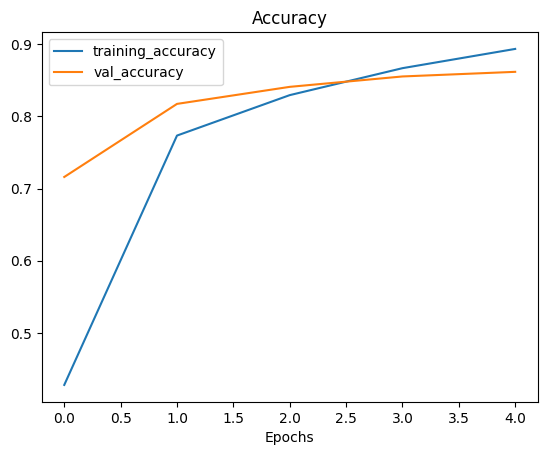

In [18]:
plot_loss_curves(efficientnet_history)

In [19]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [21]:
# # Upload tensorboard def records
# !tensorboard dev upload --logdir ./tensorflow_hub/ \
#   --name "EfficientNetB0 vs. ResNet50V2" \
#   --description "Comparing two different TF Hub feature extraction model architectures using 10% of the 10 food classes" \
#   --one_shot

In [23]:
# # Kiểm tra các experiment
# !tensorboard dev list

In [25]:
# !pip install tensorflow tensorflow-datasets

## 🛠 Bài tập thực hành
> **Lưu ý:** Các bạn cần làm phần bài tập này để chuẩn bị cho phiên review lab.

1. Xây dựng và khớp mô hình sử dụng dữ liệu giống với dữ liệu mà chúng ta có ở đây nhưng với MobileNetV2 architecture feature extraction ([`mobilenet_v2_100_224/feature_vector`](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4)) từ TensorFlow Hub; nó hoạt động như thế nào so với các mô hình khác của chúng ta?
2.Kể tên 3 mô hình phân loại hình ảnh khác nhau trên TensorFlow Hub mà chúng ta chưa bao giờ sử dụng.
3. Xây dựng mô hình phân loại hình ảnh của hai thứ khác nhau mà bạn chụp được.
  * Có thể dùng bất kỳ feature extraction layer nào từ TensorFlow Hub mà bạn muốn cho điều này.
  * Cần đặt mục tiêu có ít nhất 10 ảnh của mỗi lớp, chẳng hạn để xây dựng bộ phân loại tủ lạnh với lò vi sóng, bạn sẽ cần 10 ảnh về tủ lạnh và 10 ảnh lò vi sóng.
4. Mô hình nào đang hoạt động tốt nhất trên ImageNet?
  * Gợi ý: hãy xem [sotabench.com](https://www.sotabench.com) cho điều này.

### Xây dựng và khớp mô hình sử dụng MobileNetV2


In [26]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [28]:
# download and preprocess the datasets :
(train_data,validation_data), dataset_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:]'],
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.CPBTN4_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
#

#### 3 mô hình phân loại hình ảnh khác nhau trên TensorFlow Hub mà chúng ta chưa bao giờ sử dụng :
- https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4
- https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4
- https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4


In [30]:
# define the image size and batch size
IMG_SIZE = 224
BATCH_SIZE = 32

# format image
def format_image(image,label):
  image = tf.image.resize(image,(IMG_SIZE,IMG_SIZE))/255.0
  return image,label
train_batches = train_data.shuffle(1000).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_data.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [31]:
# download MobileNetV2 from Tensowflow Hub
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,3)
                                         )

In [32]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(2, activation='softmax')
])
model.compile (
    optimizer = 'adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [33]:
# train the model
history = model.fit(
    train_batches,
    epochs=5,
    validation_data=validation_batches
)

Epoch 1/5
582/582 [==============================] - 50s 76ms/step - loss: 0.0574 - accuracy: 0.9784 - val_loss: 0.0361 - val_accuracy: 0.9862
Epoch 2/5
582/582 [==============================] - 41s 69ms/step - loss: 0.0307 - accuracy: 0.9900 - val_loss: 0.0388 - val_accuracy: 0.9871
Epoch 3/5
582/582 [==============================] - 41s 67ms/step - loss: 0.0247 - accuracy: 0.9922 - val_loss: 0.0377 - val_accuracy: 0.9873
Epoch 4/5
582/582 [==============================] - 38s 64ms/step - loss: 0.0221 - accuracy: 0.9926 - val_loss: 0.0337 - val_accuracy: 0.9890
Epoch 5/5
582/582 [==============================] - 40s 68ms/step - loss: 0.0185 - accuracy: 0.9934 - val_loss: 0.0376 - val_accuracy: 0.9882


### Xây dựng mô hình phân loại hình ảnh của hai thứ khác nhau


In [34]:
# function to plot the loss and accuracy
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  # set the displayed variable
  loss, accuracy = history.history['loss'], history.history['accuracy']
  val_loss, val_accuracy = history.history['val_loss'], history.history['val_accuracy']
  # set the epoch range
  epochs = range(len(history.history['loss']))

  # plot the loss

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # for accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend

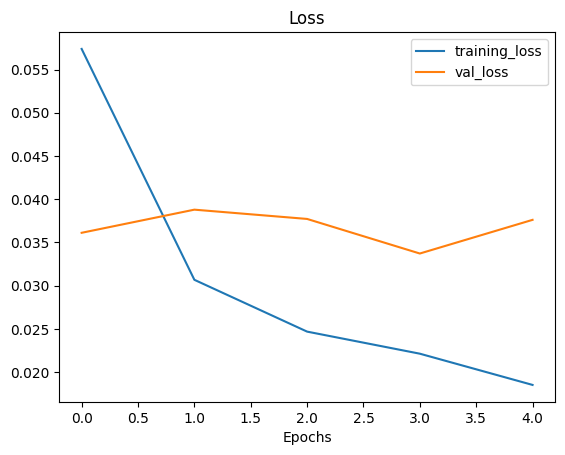

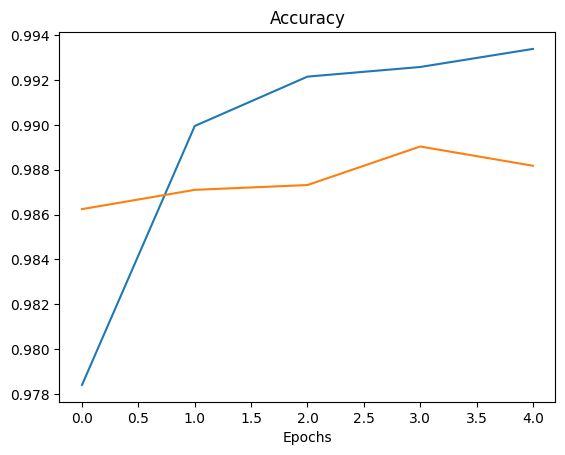

In [35]:
plot_loss_curves(history)

Epoch 1/10
582/582 [==============================] - 52s 82ms/step - loss: 0.0502 - accuracy: 0.9836 - val_loss: 0.0375 - val_accuracy: 0.9862
Epoch 2/10
582/582 [==============================] - 41s 67ms/step - loss: 0.0305 - accuracy: 0.9897 - val_loss: 0.0333 - val_accuracy: 0.9890
Epoch 3/10
582/582 [==============================] - 39s 65ms/step - loss: 0.0247 - accuracy: 0.9913 - val_loss: 0.0323 - val_accuracy: 0.9895
Epoch 4/10
582/582 [==============================] - 40s 67ms/step - loss: 0.0206 - accuracy: 0.9931 - val_loss: 0.0343 - val_accuracy: 0.9893
Epoch 5/10
582/582 [==============================] - 37s 62ms/step - loss: 0.0189 - accuracy: 0.9936 - val_loss: 0.0354 - val_accuracy: 0.9890
Epoch 6/10
582/582 [==============================] - 40s 67ms/step - loss: 0.0168 - accuracy: 0.9939 - val_loss: 0.0364 - val_accuracy: 0.9893
Epoch 7/10
582/582 [==============================] - 40s 68ms/step - loss: 0.0151 - accuracy: 0.9949 - val_loss: 0.0353 - val_accuracy:

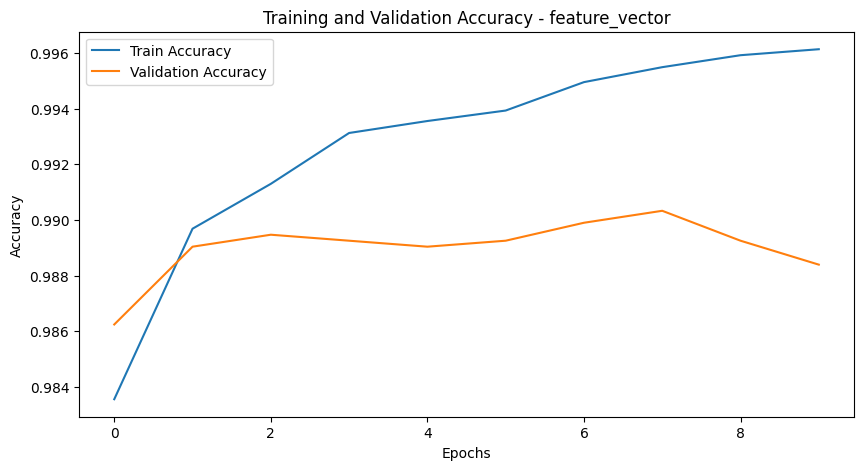

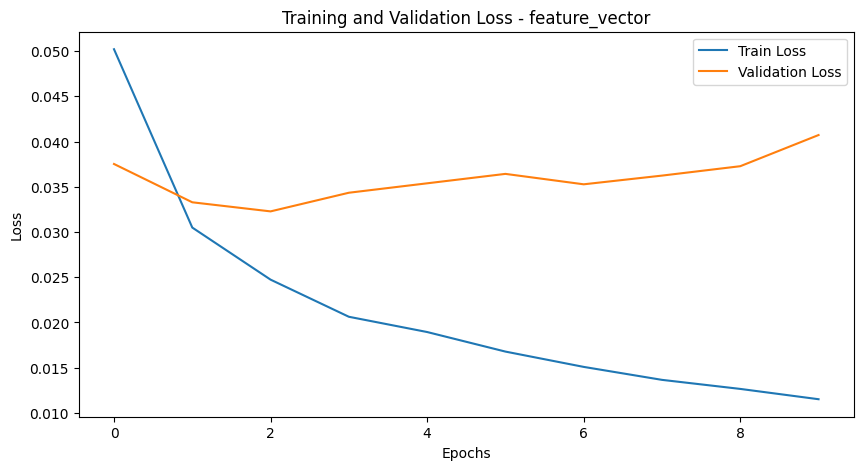

Epoch 1/10
582/582 [==============================] - 68s 99ms/step - loss: 0.0522 - accuracy: 0.9816 - val_loss: 0.0299 - val_accuracy: 0.9899
Epoch 2/10
582/582 [==============================] - 54s 91ms/step - loss: 0.0325 - accuracy: 0.9894 - val_loss: 0.0391 - val_accuracy: 0.9877
Epoch 3/10
582/582 [==============================] - 53s 89ms/step - loss: 0.0271 - accuracy: 0.9909 - val_loss: 0.0367 - val_accuracy: 0.9875
Epoch 4/10
582/582 [==============================] - 53s 90ms/step - loss: 0.0232 - accuracy: 0.9922 - val_loss: 0.0324 - val_accuracy: 0.9901
Epoch 5/10
582/582 [==============================] - 54s 91ms/step - loss: 0.0214 - accuracy: 0.9925 - val_loss: 0.0321 - val_accuracy: 0.9890
Epoch 6/10
582/582 [==============================] - 53s 88ms/step - loss: 0.0189 - accuracy: 0.9935 - val_loss: 0.0346 - val_accuracy: 0.9882
Epoch 7/10
582/582 [==============================] - 53s 89ms/step - loss: 0.0174 - accuracy: 0.9938 - val_loss: 0.0382 - val_accuracy:

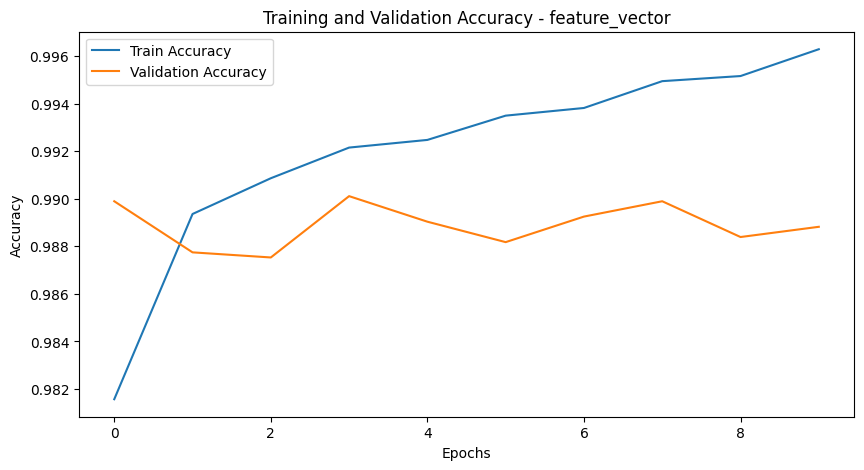

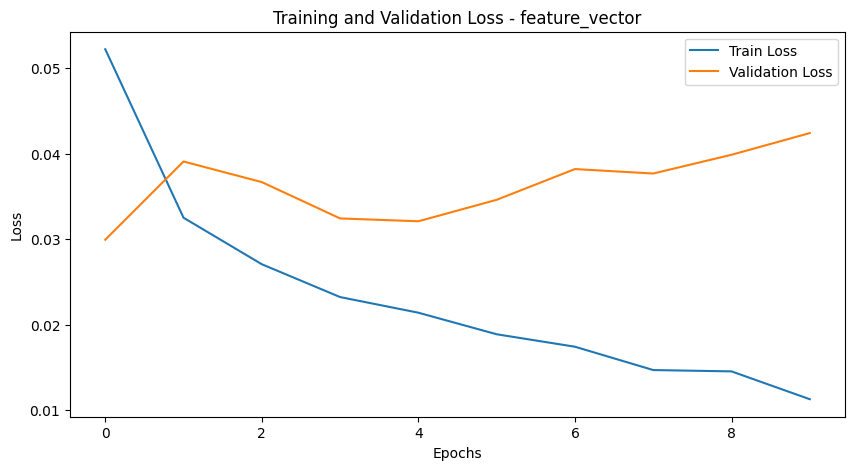

Epoch 1/10
582/582 [==============================] - 71s 114ms/step - loss: 0.0599 - accuracy: 0.9783 - val_loss: 0.0405 - val_accuracy: 0.9869
Epoch 2/10
582/582 [==============================] - 63s 107ms/step - loss: 0.0306 - accuracy: 0.9897 - val_loss: 0.0403 - val_accuracy: 0.9871
Epoch 3/10
582/582 [==============================] - 71s 120ms/step - loss: 0.0242 - accuracy: 0.9919 - val_loss: 0.0416 - val_accuracy: 0.9873
Epoch 4/10
582/582 [==============================] - 71s 121ms/step - loss: 0.0197 - accuracy: 0.9934 - val_loss: 0.0431 - val_accuracy: 0.9867
Epoch 5/10
582/582 [==============================] - 71s 121ms/step - loss: 0.0179 - accuracy: 0.9937 - val_loss: 0.0449 - val_accuracy: 0.9862
Epoch 6/10
582/582 [==============================] - 63s 106ms/step - loss: 0.0138 - accuracy: 0.9959 - val_loss: 0.0616 - val_accuracy: 0.9847
Epoch 7/10
477/582 [=======================>......] - ETA: 8s - loss: 0.0130 - accuracy: 0.9960

In [ ]:
models = [
    "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
    "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4",
    "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
]

def build_and_train_model(feature_extractor_url, train_batches, validation_batches):
    # Tải mô hình feature extraction từ TensorFlow Hub
    feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(IMG_SIZE, IMG_SIZE, 3), trainable=False)

    # Xây dựng mô hình
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(2, activation='softmax')
    ])

    # Biên dịch mô hình
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Huấn luyện mô hình
    history = model.fit(
        train_batches,
        epochs=10,
        validation_data=validation_batches
    )

    # Vẽ biểu đồ Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy - {feature_extractor_url.split("/")[-2]}')
    plt.legend()
    plt.show()

    # Vẽ biểu đồ Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss - {feature_extractor_url.split("/")[-2]}')
    plt.legend()
    plt.show()

# Huấn luyện và đánh giá từng model
for model_url in models:
    build_and_train_model(model_url, train_batches, validation_batches)
